In [18]:
# Utilities
import os
import pandas as pd
from PIL import Image

# Model
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
from collections import Counter
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import MobileNetV2, ResNet50, EfficientNetB0
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler

# Visualization
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [14]:
dataset_path = './data/leaf_coffe_dataset'  # Update this to your dataset path

# Check only image files
valid_extensions = ('.jpg', '.jpeg', '.png')

for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.lower().endswith(valid_extensions):  # Check if the file is an image
            try:
                img_path = os.path.join(root, file)
                img = Image.open(img_path)
                img.verify()
                print("Data have no corrupted image")
            except (IOError, SyntaxError) as e:
                print(f"Deleting corrupted image: {img_path}")
                os.remove(img_path)  # Delete the corrupted image

Deleting corrupted image: ./data/leaf_coffe_dataset\Healthy\2 (691).jpg


In [16]:
classes = os.listdir(dataset_path)

print("Classes:", classes)
for cls in classes:
    class_path = os.path.join(dataset_path, cls)
    print(f"Class '{cls}' contains {len(os.listdir(class_path))} images.")


Classes: ['Cerscospora', 'Healthy', 'Leaf rust', 'Miner', 'Phoma']
Class 'Cerscospora' contains 7681 images.
Class 'Healthy' contains 18983 images.
Class 'Leaf rust' contains 8336 images.
Class 'Miner' contains 16978 images.
Class 'Phoma' contains 6571 images.


Class: Cerscospora


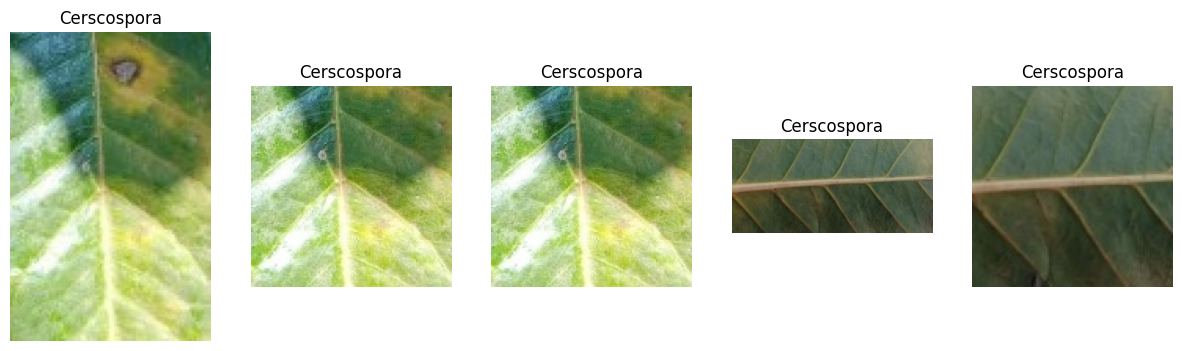

Class: Healthy


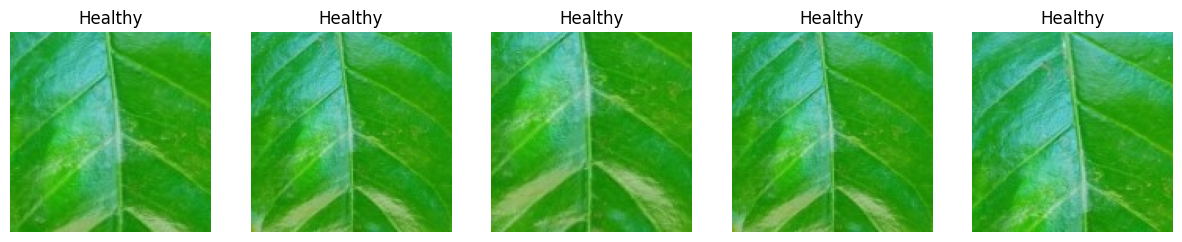

Class: Leaf rust


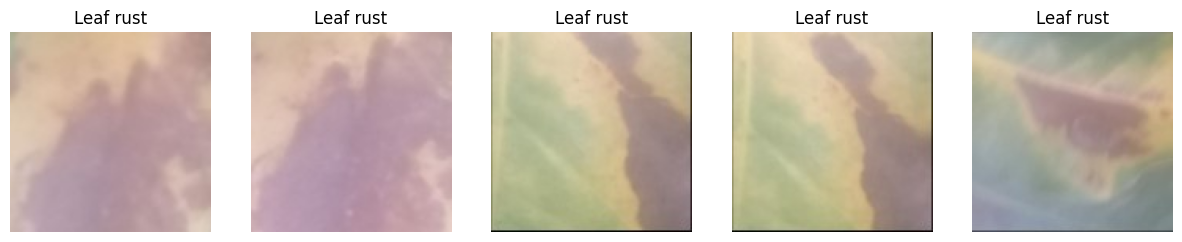

Class: Miner


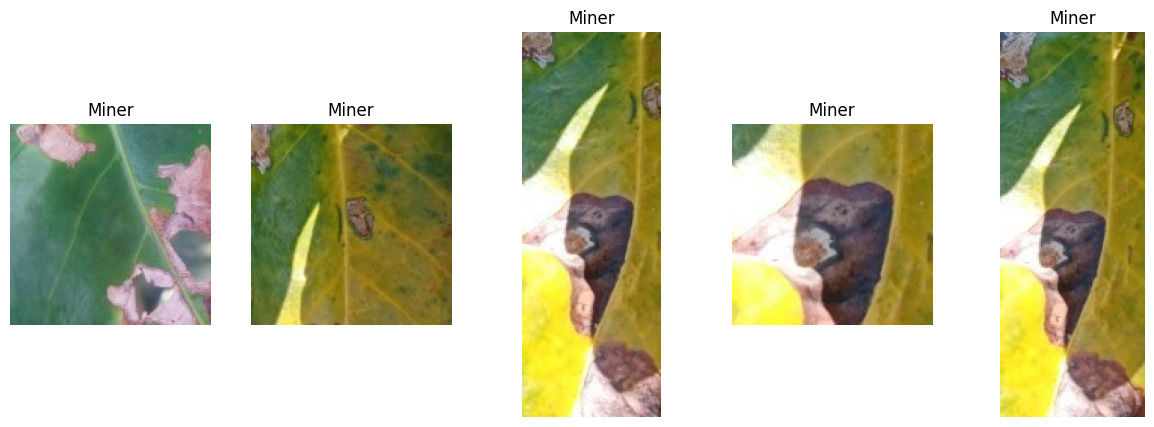

Class: Phoma


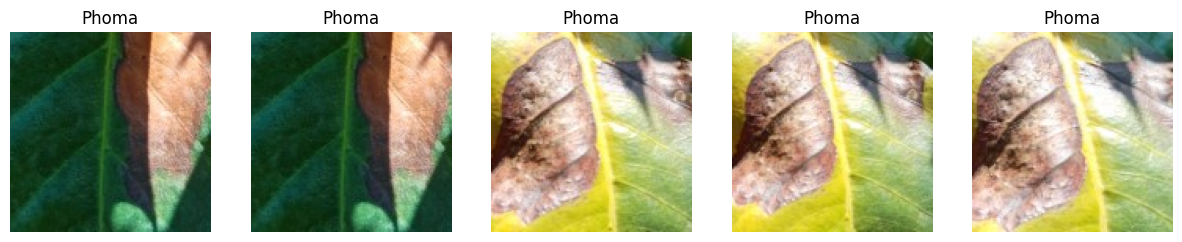

In [19]:
for cls in classes:
    class_path = os.path.join(dataset_path, cls)
    sample_images = os.listdir(class_path)[:5]  # Take 5 sample images
    print(f"Class: {cls}")
    plt.figure(figsize=(15, 5))
    for i, img_name in enumerate(sample_images):
        img_path = os.path.join(class_path, img_name)
        img = mpimg.imread(img_path)
        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.title(cls)
        plt.axis('off')
    plt.show()

In [20]:
# Step 5: Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal', input_shape=(224, 224, 3)),  # Horizontal flipping
    layers.RandomRotation(0.2),  # Random rotation in the range [-0.2, 0.2] radians
])

normalization_layer = tf.keras.layers.Rescaling(1./255)  # Normalize images to [0, 1]

In [21]:
# Step 6: Load the datasets with ImageDataset API and apply augmentation & normalization
train_ds = image_dataset_from_directory(
    dataset_path,
    image_size=(224, 224),  # Resize images to 224x224
    batch_size=32,
    validation_split=0.2,
    subset="training",
    seed=123
)

val_ds = image_dataset_from_directory(
    dataset_path,
    image_size=(224, 224),  # Resize images to 224x224
    batch_size=32,
    validation_split=0.2,
    subset="validation",
    seed=123
)

Found 58549 files belonging to 5 classes.
Using 46840 files for training.
Found 58549 files belonging to 5 classes.
Using 11709 files for validation.


In [22]:
# Step 7: Apply data augmentation and normalization
train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

# Step 8: Load Pretrained MobileNetV2 Model as Base
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),  # Input shape for MobileNetV2
    include_top=False,  # Exclude the fully connected layers at the top
    weights='imagenet'  # Use weights pre-trained on ImageNet
)

# Freeze the base model to prevent its weights from being updated during training
base_model.trainable = False

In [23]:
# Step 9: Add Custom Classifier on Top of MobileNetV2
model = models.Sequential([
    base_model,  # Add the MobileNetV2 base model
    layers.GlobalAveragePooling2D(),  # Global Average Pooling to reduce dimensions
    layers.Dense(128, activation='relu'),  # Fully connected layer
    layers.Dropout(0.2),  # Dropout for regularization
    layers.Dense(5, activation='softmax')  # Output layer (5 classes)
])

# Step 10: Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Step 11: Model Summary
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 2422597 (9.24 MB)
Trainable params: 164

In [24]:
# Step 12: Train the model
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
)

# Step 13: Evaluate the model
loss, accuracy = model.evaluate(val_ds)
print(f"Validation accuracy: {accuracy*100:.2f}%")

Epoch 1/10


1464/1464 [==============================] - 604s 410ms/step - loss: 0.0418 - accuracy: 0.9868 - val_loss: 0.0116 - val_accuracy: 0.9977
Epoch 2/10
1464/1464 [==============================] - 669s 457ms/step - loss: 0.0080 - accuracy: 0.9975 - val_loss: 0.0019 - val_accuracy: 0.9996
Epoch 3/10
1464/1464 [==============================] - 671s 458ms/step - loss: 0.0044 - accuracy: 0.9987 - val_loss: 2.4657e-04 - val_accuracy: 1.0000
Epoch 4/10
1464/1464 [==============================] - 657s 449ms/step - loss: 0.0057 - accuracy: 0.9982 - val_loss: 0.0057 - val_accuracy: 0.9981
Epoch 5/10
1464/1464 [==============================] - 646s 441ms/step - loss: 0.0052 - accuracy: 0.9983 - val_loss: 2.9834e-04 - val_accuracy: 1.0000
Epoch 6/10
1464/1464 [==============================] - 667s 455ms/step - loss: 0.0050 - accuracy: 0.9984 - val_loss: 7.2960e-05 - val_accuracy: 1.0000
Epoch 7/10
1464/1464 [==============================] - 670s 457ms/step - loss: 0.0031 - accuracy:

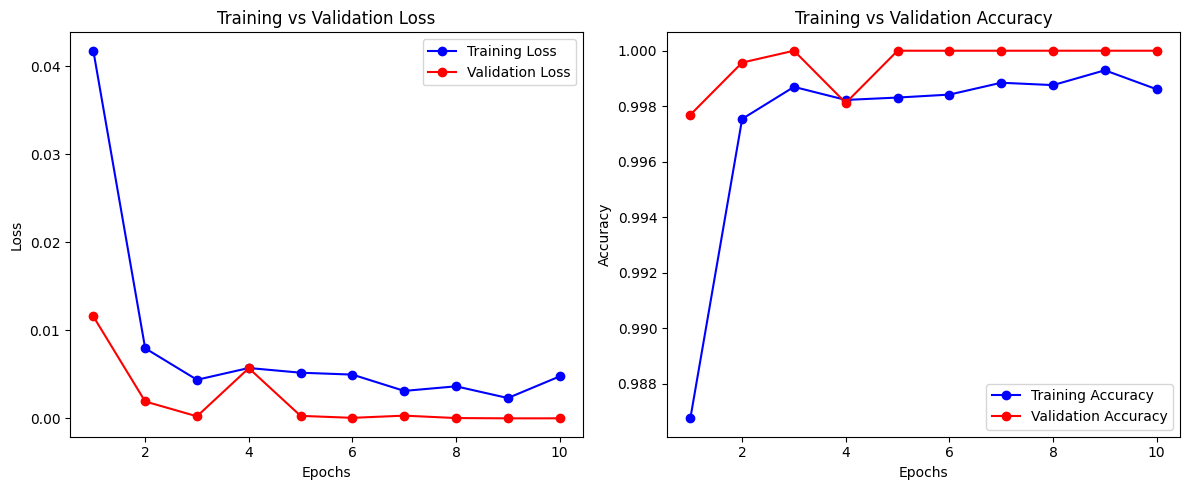

Final Training Accuracy: 99.86%
Final Validation Accuracy: 100.00%
Final Training Loss: 0.0048
Final Validation Loss: 0.0000
Model Fit Status: Good Fit


In [25]:
def plot_training_history(train_losses, val_losses, train_accs, val_accs):
    """
    Plots the training and validation loss and accuracy curves over epochs.
    
    Args:
        train_losses (list or array): Training loss values per epoch.
        val_losses (list or array): Validation loss values per epoch.
        train_accs (list or array): Training accuracy values per epoch.
        val_accs (list or array): Validation accuracy values per epoch.
    """
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(12, 5))
    
    # Plot Losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Training Loss", marker="o", color="blue")
    plt.plot(epochs, val_losses, label="Validation Loss", marker="o", color="red")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    
    # Plot Accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label="Training Accuracy", marker="o", color="blue")
    plt.plot(epochs, val_accs, label="Validation Accuracy", marker="o", color="red")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def check_fit_status(train_losses, val_losses, train_accs, val_accs, 
                     acc_diff_threshold=0.1, low_acc_threshold=0.70, loss_ratio_threshold=1.5):
    """
    Evaluates whether the model is overfitting, underfitting, or has a good fit.
    
    Args:
        train_losses (list or array): Training loss values per epoch.
        val_losses (list or array): Validation loss values per epoch.
        train_accs (list or array): Training accuracy values per epoch.
        val_accs (list or array): Validation accuracy values per epoch.
        acc_diff_threshold (float): Minimum difference between training and validation
                                    accuracy to consider overfitting (default is 0.1 i.e., 10%).
        low_acc_threshold (float): Accuracy below which the model is considered to be underfitting (default is 0.70 i.e., 70%).
        loss_ratio_threshold (float): Ratio of validation loss to training loss above which to consider overfitting (default is 1.5).
    
    Returns:
        str: One of "Overfitting", "Underfitting", or "Good Fit".
    """
    # Get final epoch values
    final_train_acc = train_accs[-1]
    final_val_acc = val_accs[-1]
    final_train_loss = train_losses[-1]
    final_val_loss = val_losses[-1]

    # Check for overfitting: training accuracy is much higher than validation accuracy
    # and validation loss is significantly higher than training loss.
    if (final_train_acc - final_val_acc) > acc_diff_threshold and (final_val_loss / final_train_loss) > loss_ratio_threshold:
        status = "Overfitting"
    # Check for underfitting: both accuracies are low.
    elif final_train_acc < low_acc_threshold and final_val_acc < low_acc_threshold:
        status = "Underfitting"
    else:
        status = "Good Fit"
    
    print("Final Training Accuracy: {:.2f}%".format(final_train_acc * 100))
    print("Final Validation Accuracy: {:.2f}%".format(final_val_acc * 100))
    print("Final Training Loss: {:.4f}".format(final_train_loss))
    print("Final Validation Loss: {:.4f}".format(final_val_loss))
    print("Model Fit Status: {}".format(status))
    
    return status

val_accs = history.history['val_accuracy']
train_accs = history.history['accuracy']
val_losses = history.history['val_loss']
train_losses = history.history['loss']

# Plot the training history
plot_training_history(train_losses, val_losses, train_accs, val_accs)

# Check the model fit status
fit_status = check_fit_status(train_losses, val_losses, train_accs, val_accs)

In [26]:
# Step 7: Handle Class Imbalance
# Calculate class weights
labels = [0] * 6571 + [1] * 8336 + [2] * 18984 + [3] * 7681 + [4] * 16978
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

NameError: name 'compute_class_weight' is not defined

In [ ]:
dataset_path = '/content/dataset'  # Update this to your dataset path

for root, dirs, files in os.walk(dataset_path):
    for file in files:
        try:
            img_path = os.path.join(root, file)
            img = Image.open(img_path)
            img.verify()  # Verifies the image is not corrupted
        except (IOError, SyntaxError) as e:
            print(f"Corrupted image: {img_path}")


In [ ]:
image_dir = '/content/dataset'  # Change this to your dataset directory

# Check each image in the directory
for img_name in os.listdir(image_dir):
    try:
        img_path = os.path.join(image_dir, img_name)
        load_img(img_path)  # Try loading the image
    except Exception as e:
        print(f"Corrupted image: {img_name} - {e}")


In [ ]:
dataset_path = '/content/dataset'  # Update this to your dataset path

# Check only image files
valid_extensions = ('.jpg', '.jpeg', '.png')

for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.lower().endswith(valid_extensions):  # Check if the file is an image
            try:
                img_path = os.path.join(root, file)
                img = Image.open(img_path)
                img.verify()  # Verifies the image is not corrupted
            except (IOError, SyntaxError) as e:
                print(f"Deleting corrupted image: {img_path}")
                os.remove(img_path)  # Delete the corrupted image


In [27]:
# 🔹 Load Pretrained ResNet50 Model as Base
base_model_resnet = ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# 🔹 Freeze base model (không huấn luyện lại các layers gốc)
base_model_resnet.trainable = False

# 🔹 Tạo model mới với head classifier riêng
model_resnet = models.Sequential([
    base_model_resnet,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(5, activation='softmax')
])

# 🔹 Compile mô hình
model_resnet.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 🔹 Xem kiến trúc mô hình ResNet50
model_resnet.summary()

# 🔹 Huấn luyện mô hình ResNet50
epochs = 10
history_resnet = model_resnet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
)

# 🔹 Đánh giá mô hình ResNet50
loss_resnet, accuracy_resnet = model_resnet.evaluate(val_ds)
print(f"📌 ResNet50 - Validation Accuracy: {accuracy_resnet*100:.2f}%")


94765736/94765736 [==============================] - 5s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 5)                 645       
                                                                 
Total params: 23850629 (90.98 MB)
Trainable params: 262

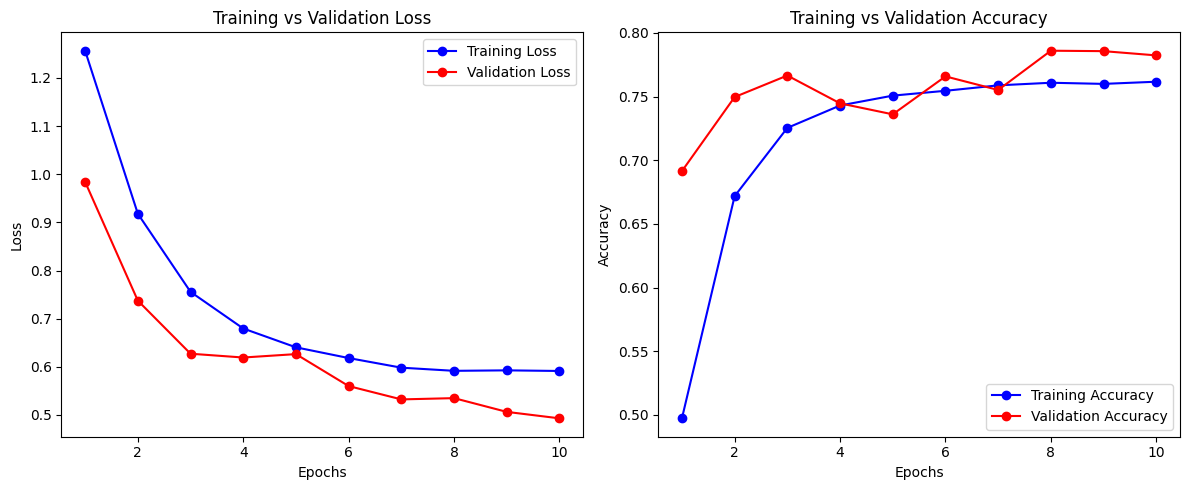

Final Training Accuracy: 76.16%
Final Validation Accuracy: 78.23%
Final Training Loss: 0.5914
Final Validation Loss: 0.4930
Model Fit Status: Good Fit


In [32]:
val_accs = history_resnet.history['val_accuracy']
train_accs = history_resnet.history['accuracy']
val_losses = history_resnet.history['val_loss']
train_losses = history_resnet.history['loss']

# Plot the training history
plot_training_history(train_losses, val_losses, train_accs, val_accs)

# Check the model fit status
fit_status = check_fit_status(train_losses, val_losses, train_accs, val_accs)

In [33]:
# 🔹 Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)



# 🔹 Load Pretrained ResNet50 Model as Base
base_model_resnet = ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# 🔹 Unfreeze một số layers cuối của ResNet50 để Fine-tuning
for layer in base_model_resnet.layers[-50:]:
    layer.trainable = True

# 🔹 Tạo model mới với head classifier riêng
model_resnet = models.Sequential([
    base_model_resnet,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(5, activation='softmax')
])

# 🔹 Compile mô hình
model_resnet.compile(
    optimizer=AdamW(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 🔹 Callbacks để tránh overfitting
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]

# 🔹 Xem kiến trúc mô hình ResNet50
model_resnet.summary()

# 🔹 Huấn luyện mô hình ResNet50
epochs = 10
history_resnet = model_resnet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks
)

# 🔹 Đánh giá mô hình ResNet50
loss_resnet, accuracy_resnet = model_resnet.evaluate(val_ds)
print(f"📌 ResNet50 - Validation Accuracy: {accuracy_resnet*100:.2f}%")

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 256)               524544    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                      

KeyboardInterrupt: 

In [ ]:
# Plot the training history
plot_training_history(train_losses, val_losses, train_accs, val_accs)

# Check the model fit status
fit_status = check_fit_status(train_losses, val_losses, train_accs, val_accs)

In [ ]:
# 🔹 Load Pretrained EfficientNetB0 Model as Base
base_model_eff = EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# 🔹 Freeze base model
base_model_eff.trainable = False

# 🔹 Tạo model mới với head classifier riêng
model_eff = models.Sequential([
    base_model_eff,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(5, activation='softmax')
])

# 🔹 Compile mô hình
model_eff.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 🔹 Xem kiến trúc mô hình EfficientNetB0
model_eff.summary()

# 🔹 Huấn luyện mô hình EfficientNetB0
epochs = 10
history_eff = model_eff.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
)

# 🔹 Đánh giá mô hình EfficientNetB0
loss_eff, accuracy_eff = model_eff.evaluate(val_ds)
print(f"📌 EfficientNetB0 - Validation Accuracy: {accuracy_eff*100:.2f}%")


In [ ]:
# 🔹 Load EfficientNetB0 Base Model
base_model = EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# 🔹 Unfreeze nhiều layers hơn khi training tiếp
for layer in base_model.layers[:-30]:  # Fine-tune 30 layers cuối
    layer.trainable = False

# 🔹 Define New Model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.LayerNormalization(),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.005)),  # Thêm 512 units
    layers.Dropout(0.3),  # Giảm Dropout để không làm mất quá nhiều thông tin
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.005)),
    layers.Dropout(0.3),
    layers.Dense(5, activation='softmax')
])

# 🔹 Optimizer & Loss
optimizer = Adam(learning_rate=5e-4)  # Tăng LR ban đầu để học nhanh hơn
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),  # Sử dụng Label Smoothing
    metrics=['accuracy']
)

# 🔹 Learning Rate Scheduler (Cosine Decay Restart)
def lr_schedule(epoch, lr):
    if epoch % 5 == 0 and epoch > 0:
        return lr * 0.5  # Giảm LR mỗi 5 epochs
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

# 🔹 Early Stopping để tránh overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 🔹 Data Augmentation (Sử dụng Mixup)
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)

# 🔹 Load dữ liệu
train_ds = train_datagen.flow_from_directory(
    'path_to_train',  # Thay đường dẫn dữ liệu
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_ds = val_datagen.flow_from_directory(
    'path_to_val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# 🔹 Train Model
epochs = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[lr_scheduler, early_stopping]
)

# 🔹 Evaluate Model
loss, accuracy = model.evaluate(val_ds)
print(f"✅ EfficientNetB0 - Validation Accuracy: {accuracy*100:.2f}%")


In [ ]:
import matplotlib.pyplot as plt

# 🔹 Hàm vẽ biểu đồ accuracy và loss
def plot_history(histories, model_names):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    for history, name in zip(histories, model_names):
        plt.plot(history.history['accuracy'], label=f'{name} Train')
        plt.plot(history.history['val_accuracy'], label=f'{name} Val')
    plt.title('📈 Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    for history, name in zip(histories, model_names):
        plt.plot(history.history['loss'], label=f'{name} Train')
        plt.plot(history.history['val_loss'], label=f'{name} Val')
    plt.title('📉 Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# 🔹 Gọi hàm vẽ biểu đồ so sánh 3 mô hình
plot_history(
    [history, history_resnet, history_eff],
    ['MobileNetV2', 'ResNet50', 'EfficientNetB0']
)


In [ ]:
print(f"✅ MobileNetV2 - Validation Accuracy: {accuracy * 100:.2f}%")
print(f"✅ ResNet50 - Validation Accuracy: {accuracy_resnet * 100:.2f}%")
print(f"✅ EfficientNetB0 - Validation Accuracy: {accuracy_eff * 100:.2f}%")
